In [9]:
import pandas as pd
import numpy as np
import xarray as xr
# import all necessary libraries
import os
import warnings
from pathlib import Path

import cartopy.feature as cfeature
import geodatasets
import geopandas as gpd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import xarray as xr
from joblib import Parallel, delayed
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
from statsmodels.graphics.tsaplots import plot_acf
from tqdm import tqdm
from utils.eda_helper_functions import plot_histogram

import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, mean_squared_error
import optuna

from utils.eda_helper_functions import (
    check_missing_times,
    group_data_hourly,
    load_insitu_data,
    load_ocean_data,
    load_weather_data,
    plot_water_level_anomalies,
    process_df,
    process_flensburg_data,
    show_df,
)
from utils.config import (
    LAT_FLENSBURG,
    LON_FLENSBURG,
    SUB_BOX,
    OCEAN_DICT,
    WEATHER_DICT,
    INSITU_DICT,
    OCEAN_POINTS,
    WEATHER_POINTS,
    )

# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Display all columns
#pd.options.display.max_columns = None






plt.rcParams.update({
    "font.size": 14,                # Grundschriftgröße (wirkt auf alles, sofern nicht überschrieben)
    "axes.titlesize": 16,           # Größe des Titels der Achse (z.B. 'Subplot Title')
    "axes.labelsize": 14,           # Achsenbeschriftung (x/y label)
    "xtick.labelsize": 12,          # X-Tick-Beschriftung
    "ytick.labelsize": 12,          # Y-Tick-Beschriftung
    "legend.fontsize": 12,          # Legendentext
    "figure.titlesize": 18,         # Gesamttitel der Abbildung (plt.suptitle)
    "figure.labelsize": 14,         # (optional, selten verwendet)
    "savefig.dpi": 300,             # DPI beim Speichern
    "figure.dpi": 100,              # DPI bei Anzeige
})


ocean_data_path = Path(f"../data/numerical_data/points{OCEAN_POINTS}")
print(ocean_data_path)
weather_data_path = Path(f"../data/numerical_data/points{WEATHER_POINTS}")
print(weather_data_path)

# save df_merged to ../data/tabular_data_FI/
file_name = f'df_merged{OCEAN_POINTS}_FI.tsv'
output_path = Path('../data/tabular_data_FI/')


/gxfs_home/geomar/smomw693/Documents/GEOMAR-DeepLearning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


../data/numerical_data/points5
../data/numerical_data/points10


In [2]:
df_ocean = load_ocean_data(ocean_data_path, OCEAN_POINTS, verbose=False)
df_ocean = process_df(df_ocean, drop_cols=["depth"], verbose=False)

df_weather = load_weather_data(weather_data_path, WEATHER_POINTS, verbose=False)
df_weather = process_df(df_weather, verbose=False, drop_cols=['showers'])

df_insitu = load_insitu_data(verbose=False)
df_insitu = process_flensburg_data(df_insitu, 
                                      start_time=df_ocean['time'].min(),
                                      end_time=df_ocean['time'].max(),
                                      verbose=False)

df_insitu = group_data_hourly(df_insitu)
df_insitu = process_df(df_insitu, drop_cols=["depth",'deph', 'latitude', 'longitude', 'time_qc', 'slev_qc'], verbose=False)


df_weather5.nc removed


In [3]:
def feature_engineering(df_ocean, df_weather, df_insitu):
    """
    Funktion zur Berechnung der u- und v-Komponenten des Windes aus der Windgeschwindigkeit und -richtung.
    """
    
    # df_weather

    # Filter from Feature Importance
    drop_features = ['siconc',
                     'snowfall',
                     'sithick',
                     'rain',
                     'precipitation',
                     'uo',
                     'weather_code',
                     'vo',
                     'cloud_cover',
                     'cloud_cover_high',
                     'thetao',
                     'cloud_cover_low',
                     'sob',
                     'cloud_cover_mid',
                     'et0_fao_evapotranspiration']
    
    for feature in drop_features:
        if feature in df_weather.columns:
            df_weather.drop(columns=[feature], inplace=True)
        if feature in df_ocean.columns:
            df_ocean.drop(columns=[feature], inplace=True)
        if feature in df_insitu.columns:
            df_insitu.drop(columns=[feature], inplace=True)
    
    # Calculate u and v components
    #Calculate Radial Wind Speed
    theta = np.deg2rad(df_weather['wind_direction_10m'])

    #    Definition der u- und v-Komponenten:
    #    u = Windgeschwindigkeit * sin(Windrichtung)
    #    v = Windgeschwindigkeit * cos(Windrichtung)
    df_weather['wind_u'] = df_weather['wind_speed_10m'] * np.sin(theta)  # positiver Wert = Wind nach Osten
    df_weather['wind_v'] = df_weather['wind_speed_10m'] * np.cos(theta)  # positiver Wert = Wind nach Norden

    # Remove the original wind speed and direction columns
    df_weather.drop(columns=['wind_speed_10m', 'wind_direction_10m'], inplace=True)

    return df_ocean, df_weather, df_insitu


df_ocean, df_weather, df_insitu = feature_engineering(df_ocean, df_weather, df_insitu)

In [6]:
display(df_ocean.head()), display(df_weather.head()), display(df_insitu.head())

,time,latitude,longitude,bottomT,mlotst,sla,so,wo
0,2022-12-03 00:00:00,55.124931,12.569346,7.879676,14.649431,-0.086606,8.395580,-2.620675e-06
1,2022-12-03 01:00:00,55.124931,12.569346,7.887771,14.657304,-0.074718,8.380219,-8.750375e-07
2,2022-12-03 02:00:00,55.124931,12.569346,7.890751,16.498772,-0.053600,8.372637,-8.495825e-07
3,2022-12-03 03:00:00,55.124931,12.569346,7.896270,16.501226,-0.050303,8.365764,-9.131213e-07
4,2022-12-03 04:00:00,55.124931,12.569346,7.902933,16.500742,-0.050954,8.355705,-9.633662e-07


,time,latitude,longitude,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,pressure_msl,surface_pressure,vapour_pressure_deficit,wind_gusts_10m,wind_u,wind_v
0,2022-12-03 00:00:00,54.938488,12.166998,4.337,79.126846,1.037,-1.760069,1029.400024,1027.880493,0.174289,53.279999,23.039972,16.560036
1,2022-12-03 01:00:00,54.938488,12.166998,4.137,81.112923,1.187,-2.126686,1029.199951,1027.679688,0.155512,48.959999,23.040005,18.719994
2,2022-12-03 02:00:00,54.938488,12.166998,4.287,80.843124,1.287,-1.999586,1029.000000,1027.480713,0.159400,50.399998,25.200001,16.199993
3,2022-12-03 03:00:00,54.938488,12.166998,4.087,78.521065,0.687,-2.143030,1028.699951,1027.180054,0.176232,49.680000,24.840017,14.759969
4,2022-12-03 04:00:00,54.938488,12.166998,4.137,75.196915,0.137,-1.981791,1028.400024,1026.880981,0.204220,48.239998,24.840012,11.879973


,time,slev
0,2022-12-03 00:00:00,0.487133
1,2022-12-03 01:00:00,0.463563
2,2022-12-03 02:00:00,0.373853
3,2022-12-03 03:00:00,0.285051
4,2022-12-03 04:00:00,0.238839


(None, None, None)

In [7]:
def convert_df_to_table(df: pd.DataFrame) -> pd.DataFrame:


    df['position'] = df.apply(lambda row: (row['latitude'], row['longitude']), axis=1)
    coordinates = df['position'].unique()

    df_merged = pd.DataFrame({'time': df['time'].unique()})
    for i in tqdm(range(len(coordinates)), desc="Processing coordinates", unit="coord", total=len(coordinates)):

        df_sub_data = df[df['position'] == coordinates[i]]
        df_sub_data = df_sub_data.drop(columns=['latitude', 'longitude'])

        cols = df_sub_data.columns.tolist()
        cols.remove('position')
        cols.remove('time')


        for col in cols:
            df_sub_data.rename(columns={col: col + '#' + str(coordinates[i])}, inplace=True)

        df_sub_data = df_sub_data.drop(columns='position')


        df_merged = df_merged.merge(df_sub_data, on='time')
        
    return df_merged


def merge_dataframes(dfs: list) -> pd.DataFrame:
    """
    Merge multiple DataFrames on the 'time' column.
    """
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = merged_df.merge(df, on='time', how='inner')

    merged_df['time'] = pd.to_datetime(merged_df['time']).dt.strftime('%Y-%m-%d %H:%M:%S')
    return merged_df



In [8]:
df_ocean_table = convert_df_to_table(df_ocean)
df_weather_table = convert_df_to_table(df_weather)
df_merged = merge_dataframes([df_ocean_table, df_weather_table, df_insitu])

Processing coordinates: 100%|██████████| 100/100 [00:09<00:00, 10.11coord/s]


In [10]:
print(f"Shape of merged DataFrame: {df_merged.shape}")
df_merged.head()

Shape of merged DataFrame: (20161, 1057)


,time,"bottomT#(55.12493133544922, 12.56934642791748)","mlotst#(55.12493133544922, 12.56934642791748)","sla#(55.12493133544922, 12.56934642791748)","so#(55.12493133544922, 12.56934642791748)","wo#(55.12493133544922, 12.56934642791748)","bottomT#(55.12493133544922, 16.04155731201172)","mlotst#(55.12493133544922, 16.04155731201172)","sla#(55.12493133544922, 16.04155731201172)","so#(55.12493133544922, 16.04155731201172)",...,"relative_humidity_2m#(57.820735931396484, 16.753246307373047)","dew_point_2m#(57.820735931396484, 16.753246307373047)","apparent_temperature#(57.820735931396484, 16.753246307373047)","pressure_msl#(57.820735931396484, 16.753246307373047)","surface_pressure#(57.820735931396484, 16.753246307373047)","vapour_pressure_deficit#(57.820735931396484, 16.753246307373047)","wind_gusts_10m#(57.820735931396484, 16.753246307373047)","wind_u#(57.820735931396484, 16.753246307373047)","wind_v#(57.820735931396484, 16.753246307373047)",slev
0,2022-12-03 00:00:00,7.879676,14.649431,-0.086606,8.395580,-2.620675e-06,9.314838,16.509672,-0.158911,7.367700,...,73.029564,-0.35,-2.621158,1033.199951,1033.199951,0.220712,37.439999,22.319973,21.240028,0.487133
1,2022-12-03 01:00:00,7.887771,14.657304,-0.074718,8.380219,-8.750375e-07,9.288813,18.548052,-0.162093,7.367309,...,76.824234,0.30,-2.908998,1033.000000,1033.000000,0.188996,43.919998,24.480024,22.319971,0.463563
2,2022-12-03 02:00:00,7.890751,16.498772,-0.053600,8.372637,-8.495825e-07,9.260718,18.547976,-0.162460,7.368689,...,71.974121,-0.55,-3.106493,1033.099976,1033.099976,0.229348,44.639996,25.560038,22.319952,0.373853
3,2022-12-03 03:00:00,7.896270,16.501226,-0.050303,8.365764,-9.131213e-07,9.231033,18.548380,-0.160485,7.371161,...,72.726585,-0.60,-3.414577,1033.000000,1033.000000,0.220077,45.719997,24.839966,24.120037,0.285051
4,2022-12-03 04:00:00,7.902933,16.500742,-0.050954,8.355705,-9.633662e-07,9.200737,18.548874,-0.158085,7.374034,...,72.442917,-0.75,-3.541094,1032.699951,1032.699951,0.220807,45.719997,23.399984,25.560017,0.238839


# Test Datensatz

In [6]:
import pandas as pd
import numpy as np

# Beispiel-Koordinaten
coords = [
    (55.12493133544922, 12.56934642791748),
    (55.12493133544922, 16.04155731201172),
    (57.820735931396484, 16.753246307373047)
]

# Beispiel-Features pro Koordinate
features = [
    "bottomT", "mlotst", "sla", "so", "wo",
    "relative_humidity_2m", "dew_point_2m", "apparent_temperature",
    "pressure_msl", "surface_pressure", "vapour_pressure_deficit",
    "wind_gusts_10m", "wind_u", "wind_v"
]

# Zeitstempel
times = pd.date_range("2022-12-03 00:00:00", periods=100, freq="h")

# Spaltennamen generieren
columns = []
for coord in coords:
    for feat in features:
        columns.append(f"{feat}#{coord}")

columns.append("slev")  # Zielspalte

# Zufallsdaten erzeugen
data = np.random.randn(len(times), len(columns)-1)
slev = np.random.rand(len(times), 1)

# DataFrame erstellen
df_test = pd.DataFrame(
    np.hstack([data, slev]),
    columns=columns
)
df_test.insert(0, "time", times)

# Ausgabe
display(df_test)

df_merged = df_test

,time,"bottomT#(55.12493133544922, 12.56934642791748)","mlotst#(55.12493133544922, 12.56934642791748)","sla#(55.12493133544922, 12.56934642791748)","so#(55.12493133544922, 12.56934642791748)","wo#(55.12493133544922, 12.56934642791748)","relative_humidity_2m#(55.12493133544922, 12.56934642791748)","dew_point_2m#(55.12493133544922, 12.56934642791748)","apparent_temperature#(55.12493133544922, 12.56934642791748)","pressure_msl#(55.12493133544922, 12.56934642791748)",...,"relative_humidity_2m#(57.820735931396484, 16.753246307373047)","dew_point_2m#(57.820735931396484, 16.753246307373047)","apparent_temperature#(57.820735931396484, 16.753246307373047)","pressure_msl#(57.820735931396484, 16.753246307373047)","surface_pressure#(57.820735931396484, 16.753246307373047)","vapour_pressure_deficit#(57.820735931396484, 16.753246307373047)","wind_gusts_10m#(57.820735931396484, 16.753246307373047)","wind_u#(57.820735931396484, 16.753246307373047)","wind_v#(57.820735931396484, 16.753246307373047)",slev
0,2022-12-03 00:00:00,-0.012551,-1.317451,0.576647,-0.395867,-0.447593,-0.124394,0.074987,0.594723,0.759256,...,-0.001196,-1.141174,-0.665862,-0.332027,0.418929,1.399886,0.801231,0.357474,-0.556743,0.877722
1,2022-12-03 01:00:00,0.944113,-0.528537,-0.246940,-0.114172,0.092166,-1.443913,-1.399996,1.380071,0.835091,...,0.535754,-0.736694,0.653826,0.946133,1.988783,-1.554375,1.086109,0.289435,0.185933,0.100759
2,2022-12-03 02:00:00,0.292240,1.457273,0.383679,-0.602850,-0.142726,-1.367576,-0.782997,0.421024,-0.354609,...,-1.330932,0.226078,0.305587,1.180283,0.322042,-0.702119,-1.150085,2.060479,-0.313484,0.296807
3,2022-12-03 03:00:00,0.165396,0.773685,-1.860786,1.906442,1.313244,0.691651,-0.714140,-0.232835,0.351169,...,1.471476,1.361646,0.684144,1.792269,0.694933,-0.025238,0.038774,1.710184,-2.410050,0.470870
4,2022-12-03 04:00:00,1.429873,-1.634669,-0.470902,1.682788,0.508837,0.859149,-1.460468,1.333183,0.391890,...,0.135908,1.273976,0.289318,0.194921,-1.502713,0.579299,0.207965,2.139588,-0.772378,0.537855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2022-12-06 23:00:00,0.778547,-1.038624,1.597926,-0.512067,0.262700,-0.305723,-0.824436,0.045100,-0.345174,...,-0.753295,2.691437,-0.747970,-1.931275,0.758089,1.423859,0.749971,-1.255809,0.414787,0.532425
96,2022-12-07 00:00:00,-1.396866,1.301740,0.183654,1.835345,-1.891603,-0.161495,0.397793,-0.229791,0.707066,...,-1.415646,-0.365708,0.274050,-0.255807,1.081498,-2.250809,-0.301115,-0.328881,0.666885,0.224077
97,2022-12-07 01:00:00,-1.720290,1.001558,0.533467,0.117034,0.023186,0.444052,-0.589370,0.668572,-1.094572,...,0.408239,-0.441045,0.000061,1.170450,1.532395,-0.769946,0.327013,0.558022,1.166052,0.594354
98,2022-12-07 02:00:00,2.067048,-0.159364,-0.876614,0.567663,-0.743008,0.525161,-0.181461,0.325884,-0.476096,...,0.419702,0.344896,-0.872443,1.098261,0.476320,-1.499665,-1.043886,1.616275,0.254253,0.198675


In [7]:
# -------------------
# 2. Feature Engineering
# -------------------

df = df_merged.copy()

n_lags = 48
n_future = 12
features = [col for col in df.columns if col not in ['time']]
print(f"Features: {features}")
print(len(features))



Features: ['bottomT#(55.12493133544922, 12.56934642791748)', 'mlotst#(55.12493133544922, 12.56934642791748)', 'sla#(55.12493133544922, 12.56934642791748)', 'so#(55.12493133544922, 12.56934642791748)', 'wo#(55.12493133544922, 12.56934642791748)', 'relative_humidity_2m#(55.12493133544922, 12.56934642791748)', 'dew_point_2m#(55.12493133544922, 12.56934642791748)', 'apparent_temperature#(55.12493133544922, 12.56934642791748)', 'pressure_msl#(55.12493133544922, 12.56934642791748)', 'surface_pressure#(55.12493133544922, 12.56934642791748)', 'vapour_pressure_deficit#(55.12493133544922, 12.56934642791748)', 'wind_gusts_10m#(55.12493133544922, 12.56934642791748)', 'wind_u#(55.12493133544922, 12.56934642791748)', 'wind_v#(55.12493133544922, 12.56934642791748)', 'bottomT#(55.12493133544922, 16.04155731201172)', 'mlotst#(55.12493133544922, 16.04155731201172)', 'sla#(55.12493133544922, 16.04155731201172)', 'so#(55.12493133544922, 16.04155731201172)', 'wo#(55.12493133544922, 16.04155731201172)', 're

In [10]:
# Lag-Features für alle Input-Features
lag_features = []
for feature in tqdm(features):
    for i in range(1, n_lags + 1):
        lag_features.append(df[feature].shift(i).rename(f"{feature}_lag_{i}"))
df_lags = pd.concat(lag_features, axis=1)
df = pd.concat([df, df_lags], axis=1)

100%|██████████| 43/43 [00:00<00:00, 548.40it/s]


In [11]:
# Ziel: water_level der nächsten 12 Stunden
target_features = []
for i in tqdm(range(1, n_future + 1)):
    target_features.append(df['slev'].shift(-i).rename(f'slev_t+{i}'))
df_targets = pd.concat(target_features, axis=1)
df = pd.concat([df, df_targets], axis=1)

df.dropna(inplace=True)

100%|██████████| 12/12 [00:00<00:00, 12608.13it/s]


In [12]:
df.head()

,time,"bottomT#(55.12493133544922, 12.56934642791748)","mlotst#(55.12493133544922, 12.56934642791748)","sla#(55.12493133544922, 12.56934642791748)","so#(55.12493133544922, 12.56934642791748)","wo#(55.12493133544922, 12.56934642791748)","relative_humidity_2m#(55.12493133544922, 12.56934642791748)","dew_point_2m#(55.12493133544922, 12.56934642791748)","apparent_temperature#(55.12493133544922, 12.56934642791748)","pressure_msl#(55.12493133544922, 12.56934642791748)",...,slev_t+3,slev_t+4,slev_t+5,slev_t+6,slev_t+7,slev_t+8,slev_t+9,slev_t+10,slev_t+11,slev_t+12
48,2022-12-05 00:00:00,0.454616,-0.372835,-1.230907,0.627157,-1.172918,-3.346259,1.781995,-1.545116,0.744851,...,0.435529,0.210058,0.039790,0.391758,0.809803,0.752352,0.925423,0.825429,0.669042,0.141962
49,2022-12-05 01:00:00,-0.436451,-0.840297,-0.029482,0.340087,0.114089,0.798440,1.089022,-0.719561,0.452487,...,0.210058,0.039790,0.391758,0.809803,0.752352,0.925423,0.825429,0.669042,0.141962,0.436699
50,2022-12-05 02:00:00,-0.192595,-1.415436,-0.872953,-0.004691,0.765118,-0.238989,1.601809,0.828312,-0.728952,...,0.039790,0.391758,0.809803,0.752352,0.925423,0.825429,0.669042,0.141962,0.436699,0.925891
51,2022-12-05 03:00:00,-0.340123,-1.550612,-0.530084,0.966107,0.923106,-2.196593,-0.861459,-2.252966,-0.012846,...,0.391758,0.809803,0.752352,0.925423,0.825429,0.669042,0.141962,0.436699,0.925891,0.972456
52,2022-12-05 04:00:00,0.805978,0.013483,0.103026,-1.266777,1.067252,-0.514164,1.397031,-0.214008,-0.566120,...,0.809803,0.752352,0.925423,0.825429,0.669042,0.141962,0.436699,0.925891,0.972456,0.639489


In [15]:
# print columns where slev in column name
slev_columns = [col for col in df.columns if 'slev' in col]
print(f"Columns containing 'slev': {slev_columns}")
df[slev_columns].head()

Columns containing 'slev': ['slev', 'slev_lag_1', 'slev_lag_2', 'slev_lag_3', 'slev_lag_4', 'slev_lag_5', 'slev_lag_6', 'slev_lag_7', 'slev_lag_8', 'slev_lag_9', 'slev_lag_10', 'slev_lag_11', 'slev_lag_12', 'slev_lag_13', 'slev_lag_14', 'slev_lag_15', 'slev_lag_16', 'slev_lag_17', 'slev_lag_18', 'slev_lag_19', 'slev_lag_20', 'slev_lag_21', 'slev_lag_22', 'slev_lag_23', 'slev_lag_24', 'slev_lag_25', 'slev_lag_26', 'slev_lag_27', 'slev_lag_28', 'slev_lag_29', 'slev_lag_30', 'slev_lag_31', 'slev_lag_32', 'slev_lag_33', 'slev_lag_34', 'slev_lag_35', 'slev_lag_36', 'slev_lag_37', 'slev_lag_38', 'slev_lag_39', 'slev_lag_40', 'slev_lag_41', 'slev_lag_42', 'slev_lag_43', 'slev_lag_44', 'slev_lag_45', 'slev_lag_46', 'slev_lag_47', 'slev_lag_48', 'slev_t+1', 'slev_t+2', 'slev_t+3', 'slev_t+4', 'slev_t+5', 'slev_t+6', 'slev_t+7', 'slev_t+8', 'slev_t+9', 'slev_t+10', 'slev_t+11', 'slev_t+12']


,slev,slev_lag_1,slev_lag_2,slev_lag_3,slev_lag_4,slev_lag_5,slev_lag_6,slev_lag_7,slev_lag_8,slev_lag_9,...,slev_t+3,slev_t+4,slev_t+5,slev_t+6,slev_t+7,slev_t+8,slev_t+9,slev_t+10,slev_t+11,slev_t+12
48,0.199192,0.732724,0.453652,0.052890,0.934106,0.118296,0.618210,0.329356,0.946090,0.805897,...,0.435529,0.210058,0.039790,0.391758,0.809803,0.752352,0.925423,0.825429,0.669042,0.141962
49,0.894539,0.199192,0.732724,0.453652,0.052890,0.934106,0.118296,0.618210,0.329356,0.946090,...,0.210058,0.039790,0.391758,0.809803,0.752352,0.925423,0.825429,0.669042,0.141962,0.436699
50,0.214930,0.894539,0.199192,0.732724,0.453652,0.052890,0.934106,0.118296,0.618210,0.329356,...,0.039790,0.391758,0.809803,0.752352,0.925423,0.825429,0.669042,0.141962,0.436699,0.925891
51,0.435529,0.214930,0.894539,0.199192,0.732724,0.453652,0.052890,0.934106,0.118296,0.618210,...,0.391758,0.809803,0.752352,0.925423,0.825429,0.669042,0.141962,0.436699,0.925891,0.972456
52,0.210058,0.435529,0.214930,0.894539,0.199192,0.732724,0.453652,0.052890,0.934106,0.118296,...,0.809803,0.752352,0.925423,0.825429,0.669042,0.141962,0.436699,0.925891,0.972456,0.639489


In [13]:
X_cols = [col for col in df.columns if any(f in col for f in features) and 'lag_' in col]
y_cols = [f'slev_t+{i}' for i in range(1, n_future + 1)]

In [ ]:

X = df[X_cols]
y = df[y_cols]

# -------------------
# 3. Optuna-Ziel-Funktion
# -------------------
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 30),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 42,
        "n_jobs": -1
    }

    model = MultiOutputRegressor(RandomForestRegressor(**params), n_jobs=-1)
    tscv = TimeSeriesSplit(n_splits=5)
    rmses = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred)
        rmses.append(rmse)

    return np.mean(rmses)

# -------------------
# 4. Optuna Study starten
# -------------------
# Storage-URL für SQLite
storage_url = "sqlite:///./optuna_study.db"
study_name = f"water_level_rf_points{OCEAN_POINTS}_ml"
study_name = f"test"
study = optuna.create_study(direction="minimize", storage=storage_url, study_name=study_name, load_if_exists=True)
study.optimize(objective, n_trials=3, n_jobs=-1)

# -------------------
# 5. Beste Parameter anzeigen
# -------------------
print("Beste Parameter:")
print(study.best_params)

[I 2025-05-30 15:01:41,399] A new study created in RDB with name: water_level_rf_points5_ml
[I 2025-05-30 15:18:36,019] Trial 1 finished with value: 0.037720740357619464 and parameters: {'n_estimators': 163, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 13, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.037720740357619464.
[I 2025-05-30 15:18:36,337] Trial 2 finished with value: 0.03761839970741911 and parameters: {'n_estimators': 102, 'max_depth': 49, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 0.03761839970741911.
[I 2025-05-30 15:22:55,408] Trial 0 finished with value: 0.03775955393166037 and parameters: {'n_estimators': 223, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.03761839970741911.


Beste Parameter:
{'n_estimators': 102, 'max_depth': 49, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}


In [21]:
# load study
study = optuna.load_study(study_name=study_name, storage=storage_url)

best_params = study.best_params

ValueError: x and y must have same first dimension, but have shapes (10,) and (12,)

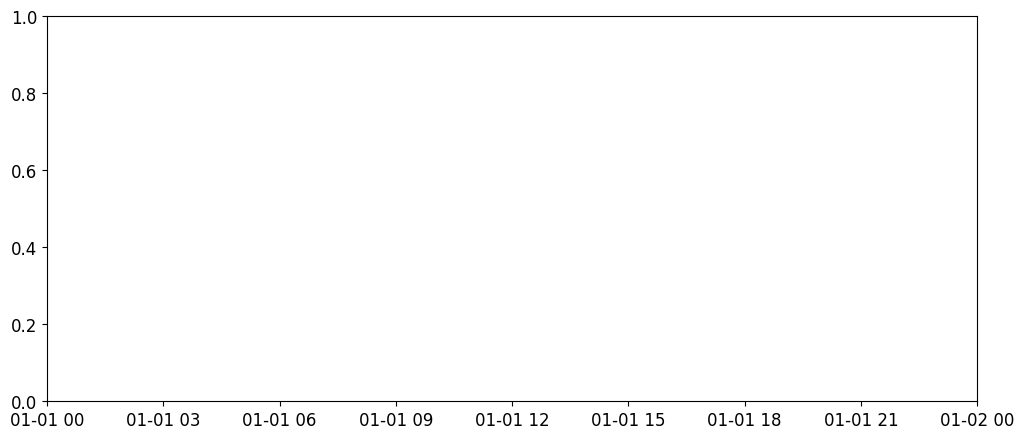

In [ ]:
import matplotlib.pyplot as plt
# Trainieren auf letztem Split
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X):
    pass

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

model = MultiOutputRegressor(RandomForestRegressor(**best_params), n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



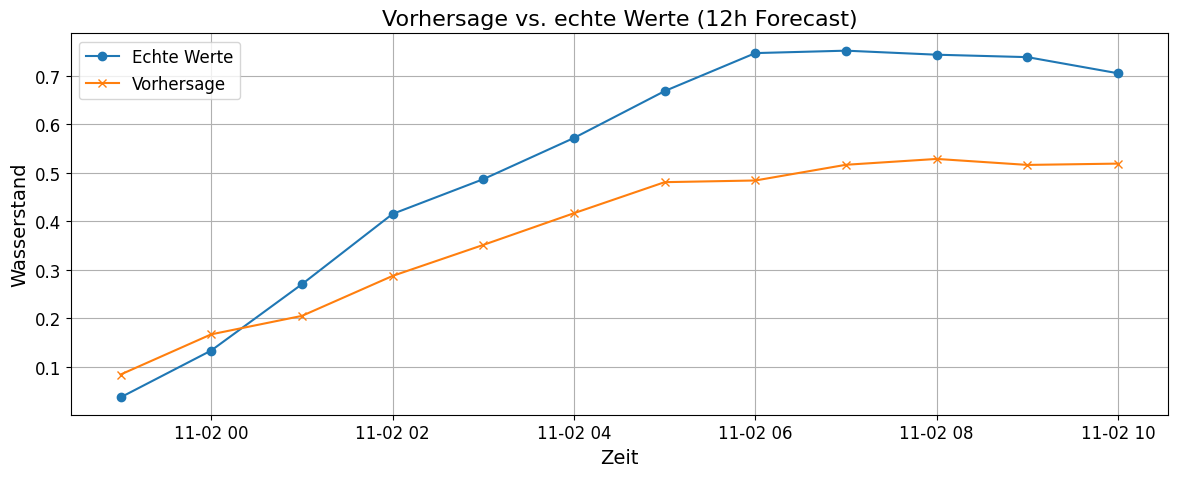

In [28]:
# Plot für das erste Beispiel im Testset
idx = 0
true_series = y_test.iloc[idx].values
pred_series = y_pred[idx]
forecast_hours = pd.date_range(start=df.iloc[test_idx[idx]].time, periods=12, freq='h')

plt.figure(figsize=(12, 5))
plt.plot(forecast_hours, true_series, label='Echte Werte', marker='o')
plt.plot(forecast_hours, pred_series, label='Vorhersage', marker='x')
plt.xlabel('Zeit')
plt.ylabel('Wasserstand')
plt.title('Vorhersage vs. echte Werte (12h Forecast)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()